In [6]:
!pip install pandas
!pip install matplotlib

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [7]:
def load_combine(csv_files):
    columns_to_analyze = [
        'accuracy', 'f1', 'fpr', 'fnr',
    ]
    ndfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        ndfs.append(df)
    combined_df = pd.concat(ndfs, ignore_index=True)  
    return combined_df

In [8]:
# def compute_mean_std(attack,combined_df ) -> None:
#     attack_df = combined_df[combined_df['Attack Type'] == attack]
    
#     # Store epsilons in a dictionary
#     epsilons = {
#         'eps1': attack_df[attack_df['Epsilon'] == 0.00],
#         'eps2': attack_df[attack_df['Epsilon'] == 0.01],
#         'eps3': attack_df[attack_df['Epsilon'] == 0.10],
#         'eps4': attack_df[attack_df['Epsilon'] == 0.15],
#     }
    
#     for name, df in epsilons.items():
#         # Drop non-metric columns
#         metrics_df = df.drop(columns=['Run ID', 'Epsilon', 'Attack Type','loss','recall','roc_auc', 'precision','pr_auc'], errors='ignore')
#         print(metrics_df.head())
#         # Calculate mean and std
#         mean_series = (metrics_df.mean() * 100).round(2)
#         std_series = (metrics_df.std() * 100).round(2)
        
        
#         # Combine into a single DataFrame
#         result_df = pd.DataFrame([mean_series, std_series], index=['mean', 'std'])
        
#         print(f"\n{name} (Epsilon = {df['Epsilon'].iloc[0]}):")
#         print(result_df)


def compute_mean_std(attack, combined_df):
    attack_df = combined_df[combined_df['Attack Type'] == attack]
    
    # Store epsilons in a dictionary
    epsilons = {
        0.00: attack_df[attack_df['Epsilon'] == 0.00],
        0.01: attack_df[attack_df['Epsilon'] == 0.01],
        0.10: attack_df[attack_df['Epsilon'] == 0.10],
        0.15: attack_df[attack_df['Epsilon'] == 0.15],
    }
    
    results = {}

    for epsilon_val, df in epsilons.items():
        # Drop non-metric columns
        metrics_df = df.drop(columns=[
            'Run ID', 'Epsilon', 'Attack Type',
            'loss', 'recall', 'roc_auc', 'precision', 'pr_auc'
        ], errors='ignore')
        
        # Skip if there's no relevant data
        if metrics_df.empty:
            continue
        
        # Calculate mean and std
        mean_series = (metrics_df.mean() * 100).round(1)
        std_series = (metrics_df.std() * 100).round(1)

        # Combine into a DataFrame
        result_df = pd.DataFrame([mean_series, std_series], index=['mean', 'std'])

        results[epsilon_val] = result_df

    return results

In [29]:
# def plot_accuracy_vs_epsilon_multi(results_dicts, attack,name):
#     plt.figure(figsize=(8, 5))

#     # Define a style map for different layer settings
#     style_map = {
#         '2 Layers': {'color': '#377eb8', 'linestyle': '--', 'marker': 's'},
#         '5 Layers': {'color': '#ff7f00', 'linestyle': '-', 'marker': 'o'},
#         '10 Layers': {'color': '#4daf4a', 'linestyle': ':', 'marker': '^'},
#         '50 Layers': {'color': '#984ea3', 'linestyle': '-.', 'marker': 'd'}
#     }

#     for label, results in results_dicts:
#         stats = []
#         for epsilon, df in sorted(results.items()):
#             if 'accuracy' in df.columns:
#                 mean_acc = df.loc['mean', 'accuracy']
#                 std_acc = df.loc['std', 'accuracy']
#                 stats.append({
#                     'Epsilon': epsilon,
#                     'Mean': mean_acc,
#                     'Std': std_acc
#                 })

#         if not stats:
#             continue

#         stats_df = pd.DataFrame(stats).dropna().sort_values(by='Epsilon')
#         epsilons = stats_df["Epsilon"].values
#         means = stats_df["Mean"].values
#         stds = stats_df["Std"].values

#         style = style_map.get(label, {})
#         plt.errorbar(
#             x=range(len(epsilons)),
#             y=means,
#             yerr=stds,
#             label=label,
#             fmt=style.get('linestyle', '-') + style.get('marker', 'o'),
#             color=style.get('color', None),
#             capsize=5,
#             markersize=6,
#             linewidth=4
#         )

#     # plt.title(f"Accuracy vs. Epsilon ({attack.upper()} Attack)", fontsize=18, fontweight='bold')
#     plt.xlabel("Epsilon", fontsize=20, fontweight='bold')
#     plt.ylabel("Accuracy (%)", fontsize=20, fontweight='bold')
#     plt.xticks(ticks=range(len(epsilons)), labels=[str(e) for e in epsilons], fontsize=14)
#     # plt.yticks(fontsize=20)
#     plt.yticks([0, 20, 40, 60,80,100], fontsize=20)
#     plt.xticks(fontsize=20)
#     # plt.ylim(0, 100)
#     # plt.xlim(-0.01, 0.16)
#     plt.ylim(0, 100)
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.legend(fontsize=20, frameon=True)
#     plt.tight_layout()
#     plt.savefig(f"{attack}_{name}_AccVSeps.png", dpi=300, bbox_inches='tight')
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_accuracy_vs_epsilon_multi(results_dicts, attack, name):
    plt.figure(figsize=(10, 6))

    # Define a style map for different layer settings
    style_map = {
        '2 Layers': {'color': '#377eb8'},
        '5 Layers': {'color': '#ff7f00'},
        '10 Layers': {'color': '#4daf4a'},
        '50 Layers': {'color': '#984ea3'}
    }

    bar_width = 0.2
    spacing = 0.05  # space between bar groups
    n_groups = len(results_dicts)
    
    # Extract all unique epsilons
    epsilons_all = sorted(list(set(eps for _, results in results_dicts for eps in results.keys())))
    x = np.arange(len(epsilons_all))  # base x positions for each epsilon

    for i, (label, results) in enumerate(results_dicts):
        means = []
        stds = []

        for eps in epsilons_all:
            df = results.get(eps)
            if df is not None and 'accuracy' in df.columns:
                mean_acc = df.loc['mean', 'accuracy']
                std_acc = df.loc['std', 'accuracy']
            else:
                mean_acc = np.nan
                std_acc = 0
            means.append(mean_acc)
            stds.append(std_acc)

        offset = (i - (n_groups - 1) / 2) * (bar_width + spacing)
        plt.bar(x + offset, means, width=bar_width, yerr=stds, capsize=5,
                label=label, color=style_map.get(label, {}).get('color', None),
                edgecolor='black')

    # Labels and formatting
    plt.xlabel("Epsilon", fontsize=30, fontweight='bold')
    plt.ylabel("Accuracy (%)", fontsize=30, fontweight='bold')
    plt.xticks(x, [str(e) for e in epsilons_all], fontsize=30)
    plt.yticks([0, 20, 40, 60, 80, 100], fontsize=30)
    plt.ylim(0, 100)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(fontsize=24, frameon=True)
    plt.tight_layout()
    plt.savefig(f"{attack}_{name}_AccVSeps_Bar.png", dpi=300, bbox_inches='tight')
    plt.show()


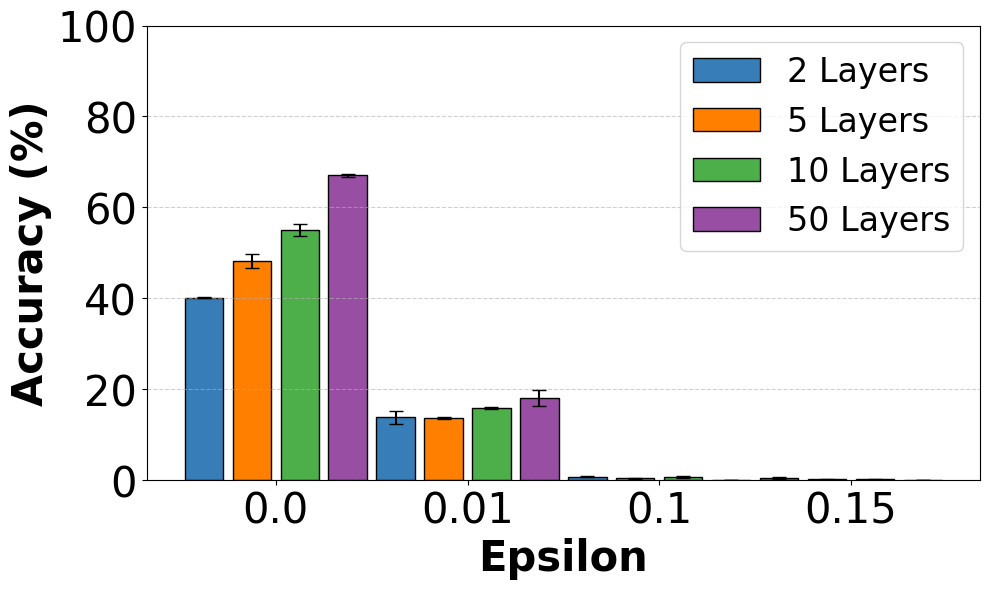

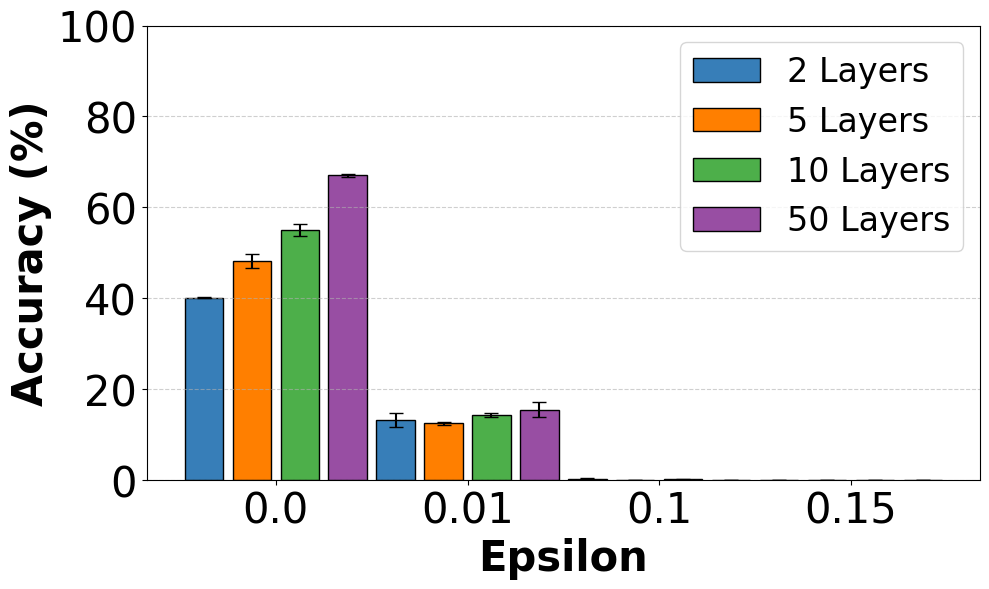

In [30]:
df_2 = load_combine([
    'qmlp-az-run_run1-layer2_Amplitude_all_attacks.csv',
    'qmlp-az-run_run2-layer2_Amplitude_all_attacks.csv',
    'qmlp-az-run_run3-layer2_Amplitude_all_attacks.csv'
])
df_5 = load_combine([
    'qmlp-az-run_run1-layer5_Amplitude_all_attacks.csv',
    'qmlp-az-run_run2-layer5_Amplitude_all_attacks.csv',
    'qmlp-az-run_run3-layer5_Amplitude_all_attacks.csv'
])
df_10 = load_combine([
    'qmlp-az-run_run1-layer10_Amplitude_all_attacks.csv',
    'qmlp-az-run_run2-layer10_Amplitude_all_attacks.csv',
    'qmlp-az-run_run3-layer10_Amplitude_all_attacks.csv'
])
df_50 = load_combine([
    'qmlp-az-run_run1-layer50_Amplitude_all_attacks.csv',
    'qmlp-az-run_run2-layer50_Amplitude_all_attacks.csv',
    'qmlp-az-run_run3-layer50_Amplitude_all_attacks.csv'
])
# print('FGSM')
# compute_mean_std('fgsm',df)
fgsm_2 = compute_mean_std('fgsm', df_2)
fgsm_5 = compute_mean_std('fgsm', df_5)
fgsm_10 = compute_mean_std('fgsm', df_10)
fgsm_50 = compute_mean_std('fgsm', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", fgsm_2),
    ("5 Layers", fgsm_5),
    ("10 Layers", fgsm_10),
    ("50 Layers", fgsm_50)
], attack='fgsm', name='Az-amplitude')


# print('PGD')
# compute_mean_std('pgd',df)

pgd_2 = compute_mean_std('pgd', df_2)
pgd_5 = compute_mean_std('pgd', df_5)
pgd_10 = compute_mean_std('pgd', df_10)
pgd_50 = compute_mean_std('pgd', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", pgd_2),
    ("5 Layers", pgd_5),
    ("10 Layers", pgd_10),
    ("50 Layers", pgd_50)
], attack='pgd', name='Az-amplitude')


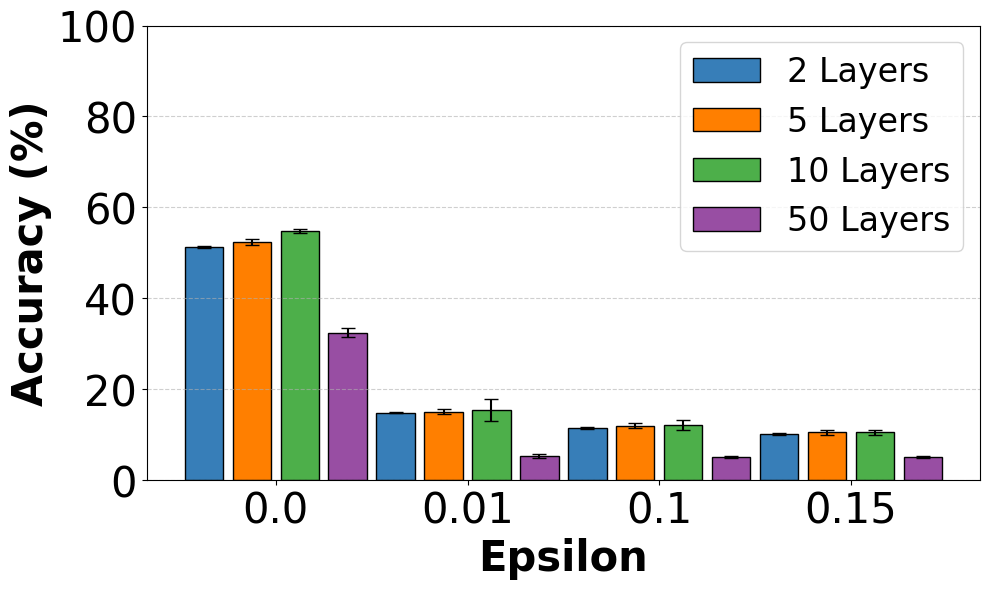

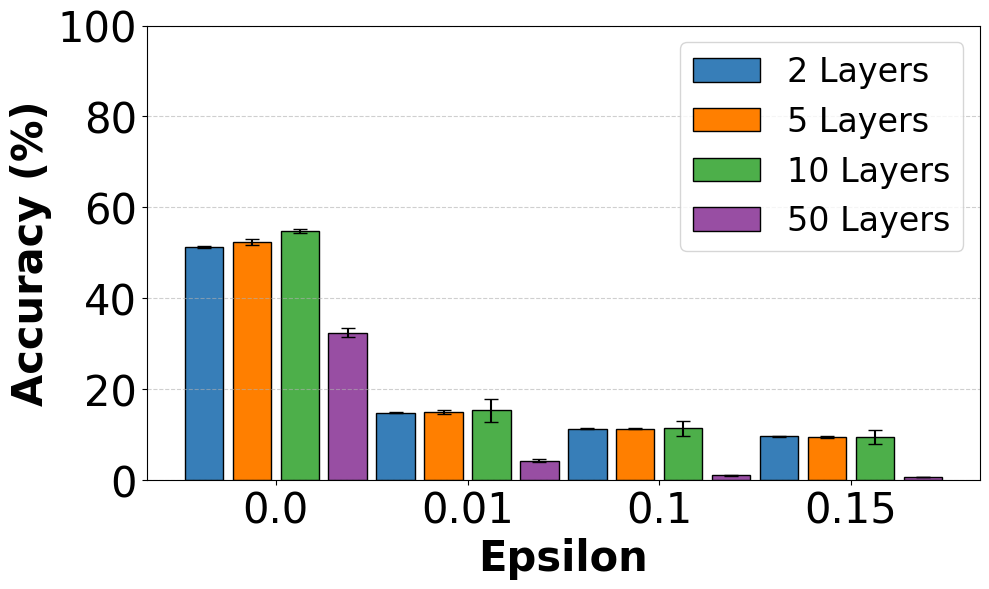

In [31]:
df_2 = load_combine([
    'qmlp-az-run_run1-layer2_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run2-layer2_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run3-layer2_Angle_Angle_all_attacks.csv'
])
df_5 = load_combine([
    'qmlp-az-run_run1-layer5_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run2-layer5_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run3-layer5_Angle_Angle_all_attacks.csv'
])
df_10 = load_combine([
    'qmlp-az-run_run1-layer10_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run2-layer10_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run3-layer10_Angle_Angle_all_attacks.csv'
])
df_50 = load_combine([
    'qmlp-az-run_run1-layer50_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run2-layer50_Angle_Angle_all_attacks.csv',
    'qmlp-az-run_run3-layer50_Angle_Angle_all_attacks.csv'
])
# print('FGSM')
# compute_mean_std('fgsm',df)
fgsm_2 = compute_mean_std('fgsm', df_2)
fgsm_5 = compute_mean_std('fgsm', df_5)
fgsm_10 = compute_mean_std('fgsm', df_10)
fgsm_50 = compute_mean_std('fgsm', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", fgsm_2),
    ("5 Layers", fgsm_5),
    ("10 Layers", fgsm_10),
    ("50 Layers", fgsm_50)
], attack='fgsm', name='Az-angle')


# print('PGD')
# compute_mean_std('pgd',df)

pgd_2 = compute_mean_std('pgd', df_2)
pgd_5 = compute_mean_std('pgd', df_5)
pgd_10 = compute_mean_std('pgd', df_10)
pgd_50 = compute_mean_std('pgd', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", pgd_2),
    ("5 Layers", pgd_5),
    ("10 Layers", pgd_10),
    ("50 Layers", pgd_50)
], attack='pgd', name='Az-angle')

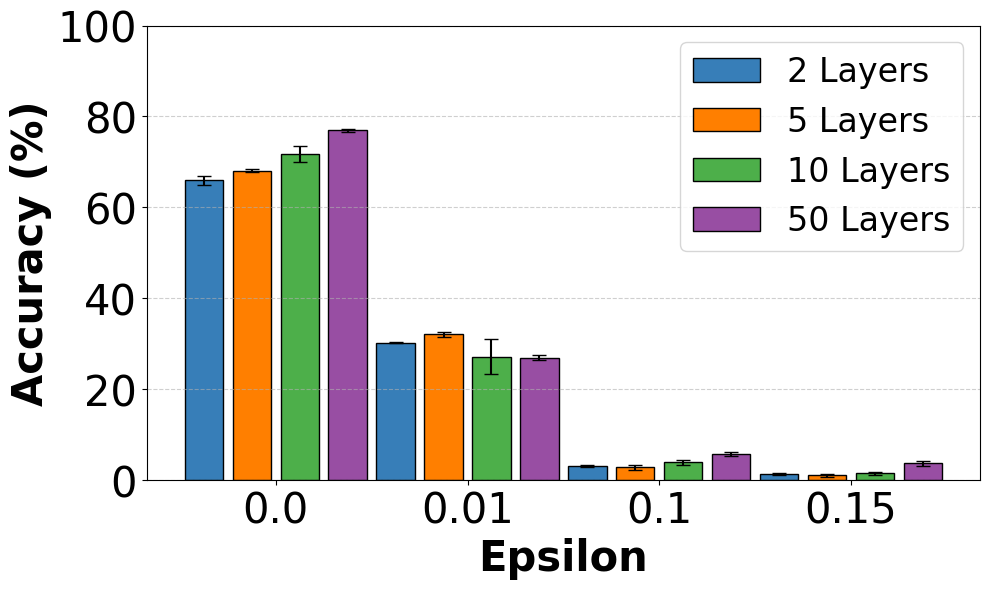

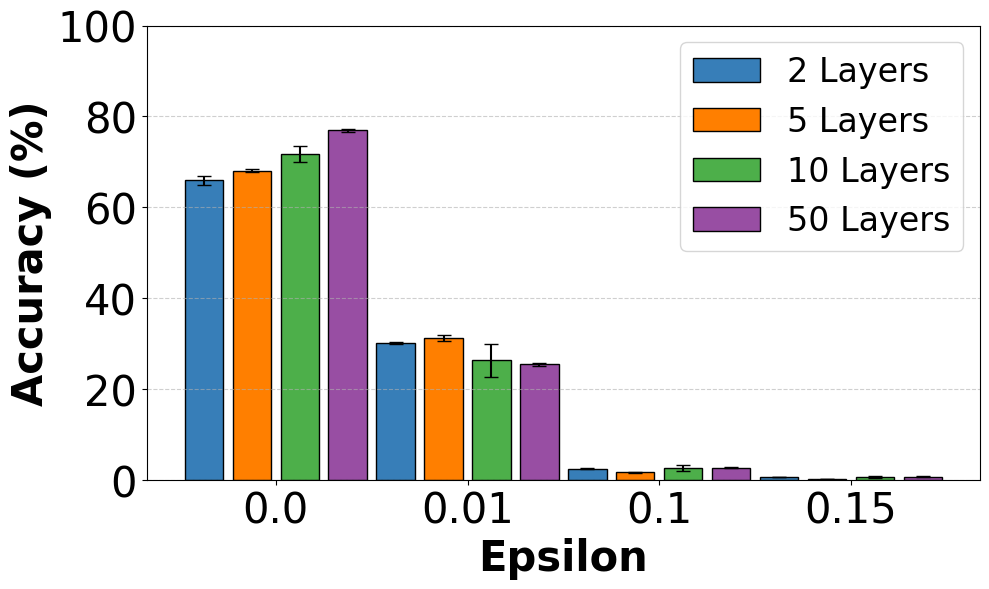

In [32]:
df_2 = load_combine([
    'qmlp-mnist-run_run1-layer2_Angle_all_attacks.csv',
    'qmlp-mnist-run_run2-layer2_Angle_all_attacks.csv',
    'qmlp-mnist-run_run3-layer2_Angle_all_attacks.csv'
])
df_5 = load_combine([
    'qmlp-mnist-run_run1-layer5_Angle_all_attacks.csv',
    'qmlp-mnist-run_run2-layer5_Angle_all_attacks.csv',
    'qmlp-mnist-run_run3-layer5_Angle_all_attacks.csv'
])
df_10 = load_combine([
    'qmlp-mnist-run_run1-layer10_Angle_all_attacks.csv',
    'qmlp-mnist-run_run2-layer10_Angle_all_attacks.csv',
    'qmlp-mnist-run_run3-layer10_Angle_all_attacks.csv'
])
df_50 = load_combine([
    'qmlp-mnist-run_run1-layer50_Angle_all_attacks.csv',
    'qmlp-mnist-run_run2-layer50_Angle_all_attacks.csv',
    'qmlp-mnist-run_run3-layer50_Angle_all_attacks.csv'
])
# print('FGSM')
# compute_mean_std('fgsm',df)
fgsm_2 = compute_mean_std('fgsm', df_2)
fgsm_5 = compute_mean_std('fgsm', df_5)
fgsm_10 = compute_mean_std('fgsm', df_10)
fgsm_50 = compute_mean_std('fgsm', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", fgsm_2),
    ("5 Layers", fgsm_5),
    ("10 Layers", fgsm_10),
    ("50 Layers", fgsm_50)
], attack='fgsm', name='mnist-angle')


# print('PGD')
# compute_mean_std('pgd',df)

pgd_2 = compute_mean_std('pgd', df_2)
pgd_5 = compute_mean_std('pgd', df_5)
pgd_10 = compute_mean_std('pgd', df_10)
pgd_50 = compute_mean_std('pgd', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", pgd_2),
    ("5 Layers", pgd_5),
    ("10 Layers", pgd_10),
    ("50 Layers", pgd_50)
], attack='pgd', name='mnist-angle')

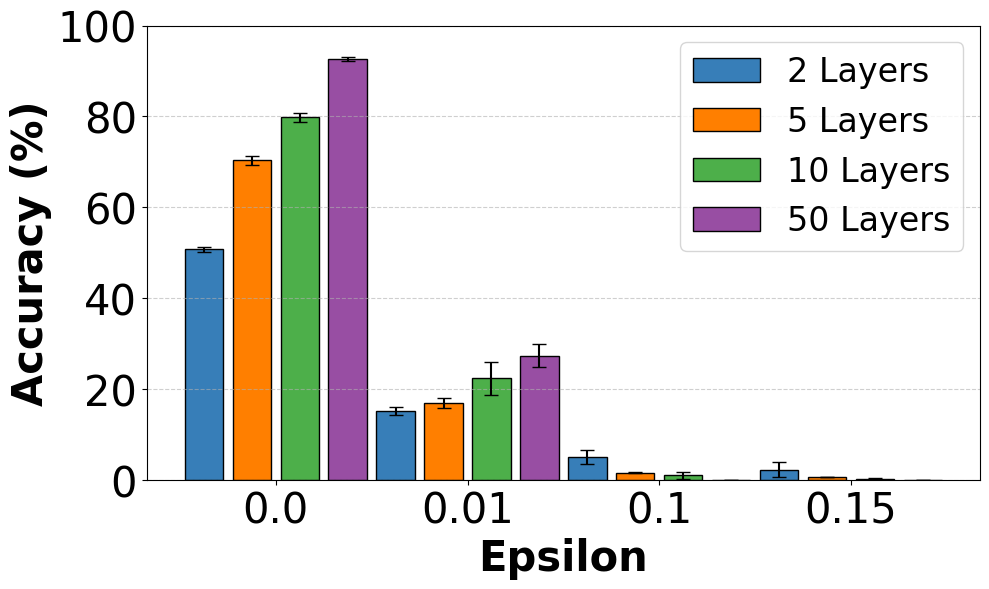

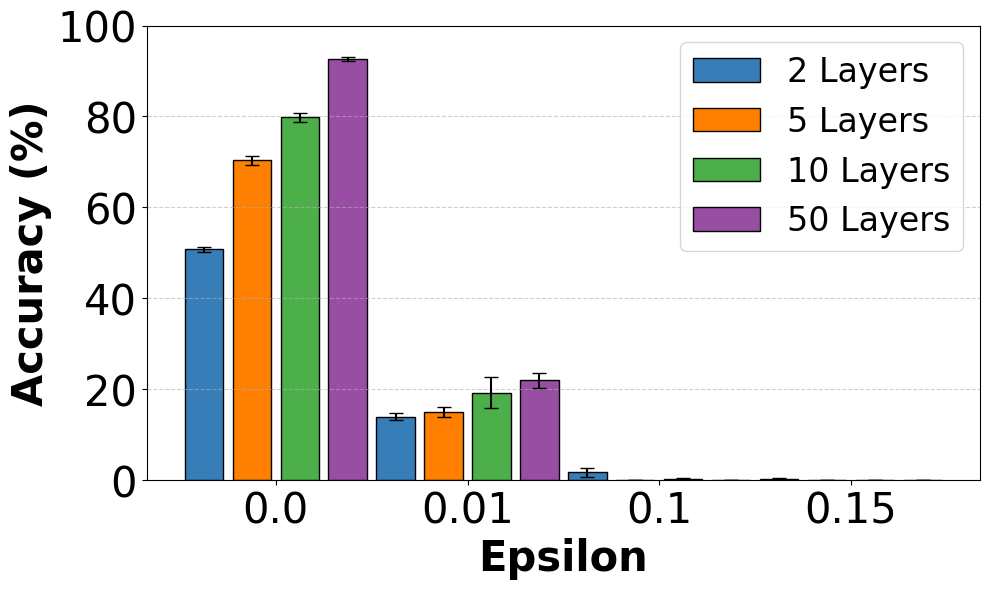

In [33]:

df_2 = load_combine([
    'qmlp-mnist-run_run1-layer2_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run2-layer2_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run3-layer2_Amplitude_all_attacks.csv'
])
df_5 = load_combine([
    'qmlp-mnist-run_run1-layer5_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run2-layer5_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run3-layer5_Amplitude_all_attacks.csv'
])
df_10 = load_combine([
    'qmlp-mnist-run_run1-layer10_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run2-layer10_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run3-layer10_Amplitude_all_attacks.csv'
])
df_50 = load_combine([
    'qmlp-mnist-run_run1-layer50_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run2-layer50_Amplitude_all_attacks.csv',
    'qmlp-mnist-run_run3-layer50_Amplitude_all_attacks.csv'
])
# print('FGSM')
# compute_mean_std('fgsm',df)
fgsm_2 = compute_mean_std('fgsm', df_2)
fgsm_5 = compute_mean_std('fgsm', df_5)
fgsm_10 = compute_mean_std('fgsm', df_10)
fgsm_50 = compute_mean_std('fgsm', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", fgsm_2),
    ("5 Layers", fgsm_5),
    ("10 Layers", fgsm_10),
    ("50 Layers", fgsm_50)
], attack='fgsm', name='mnist-amplitude')


# print('PGD')
# compute_mean_std('pgd',df)

pgd_2 = compute_mean_std('pgd', df_2)
pgd_5 = compute_mean_std('pgd', df_5)
pgd_10 = compute_mean_std('pgd', df_10)
pgd_50 = compute_mean_std('pgd', df_50)

plot_accuracy_vs_epsilon_multi([
    ("2 Layers", pgd_2),
    ("5 Layers", pgd_5),
    ("10 Layers", pgd_10),
    ("50 Layers", pgd_50)
], attack='pgd', name='mnist-amplitude')